In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pytz
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
train_data_X =pd.read_csv("https://raw.githubusercontent.com/robertmessan/ChallengeElmy/main/X_train_Wwou3IE.csv")
train_data_y= pd.read_csv("https://raw.githubusercontent.com/robertmessan/ChallengeElmy/main/y_train_jJtXgMX.csv")
train_data = pd.merge(train_data_X, train_data_y, on='DELIVERY_START', how='inner')

La fonction pour convertir la chaîne de caractères en datetime

In [3]:
def convertir_timestamp(timestamp):
    timestamp_str = str(timestamp)

    dt = datetime.strptime(timestamp_str[:19], '%Y-%m-%d %H:%M:%S')

    offset_sign = 1 if timestamp_str[-6] == '+' else -1
    offset_hours = int(timestamp_str[-5:-3])
    offset_minutes = int(timestamp_str[-2:])

    total_offset_minutes = offset_sign * (offset_hours * 60 + offset_minutes)
    offset = timedelta(minutes=total_offset_minutes)

    dt = dt - offset

    return dt

In [4]:
index=train_data['DELIVERY_START'].apply(convertir_timestamp)
train_data.set_index(index, inplace=True)
df=train_data

In [5]:
# Séparation des données en train et test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Variable cible
y_train = train['spot_id_delta']
y_test = test['spot_id_delta']

Modèle SARIMA ou ARIMA

C:\Users\thinkpad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thinkpad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thinkpad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thinkpad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

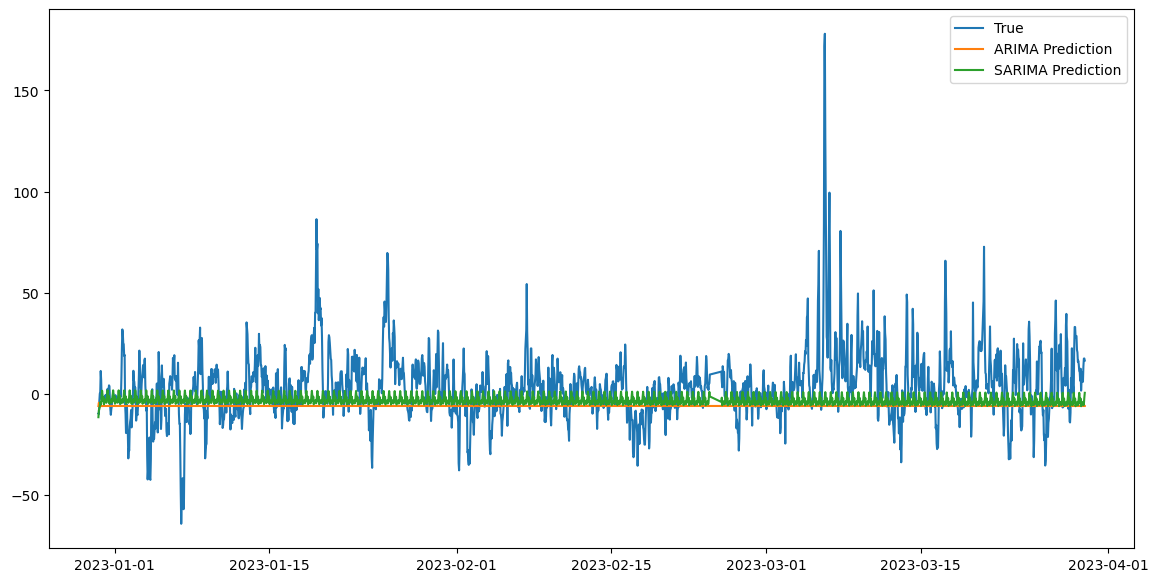

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# ARIMA
arima_model = ARIMA(y_train, order=(3, 1, 0))
arima_result = arima_model.fit()

# SARIMA
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Prédictions ARIMA
arima_pred = arima_result.forecast(steps=len(y_test))

# Prédictions SARIMA
sarima_pred = sarima_result.forecast(steps=len(y_test))

# Visualisation
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, arima_pred, label='ARIMA Prediction')
plt.plot(y_test.index, sarima_pred, label='SARIMA Prediction')
plt.legend()
plt.show()


In [7]:
# Calcul des erreurs
arima_rmse = mean_squared_error(y_test, arima_pred, squared=False)
sarima_rmse = mean_squared_error(y_test, sarima_pred, squared=False)
arima_mape = mean_absolute_percentage_error(y_test, arima_pred)
sarima_mape = mean_absolute_percentage_error(y_test, sarima_pred)

print(f'ARIMA RMSE: {arima_rmse}, MAPE: {arima_mape} %')
print(f'SARIMA RMSE: {sarima_rmse}, MAPE: {sarima_mape} %')

ARIMA RMSE: 19.128159293191857, MAPE: 30.04130039902236 %
SARIMA RMSE: 18.042061731019988, MAPE: 23.612987598184606 %


C:\Users\thinkpad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\thinkpad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 42732.99706122363
Iteration:      2,   Func. Count:     12,   Neg. LLF: 50605.87736010315
Iteration:      3,   Func. Count:     19,   Neg. LLF: 38704.20782262959
Iteration:      4,   Func. Count:     24,   Neg. LLF: 38637.98453734992
Iteration:      5,   Func. Count:     29,   Neg. LLF: 38623.35885862286
Iteration:      6,   Func. Count:     34,   Neg. LLF: 38622.85167369723
Iteration:      7,   Func. Count:     39,   Neg. LLF: 38622.694819136574
Iteration:      8,   Func. Count:     44,   Neg. LLF: 38622.684702566396
Iteration:      9,   Func. Count:     49,   Neg. LLF: 38622.684150153014
Iteration:     10,   Func. Count:     54,   Neg. LLF: 38622.68409107796
Iteration:     11,   Func. Count:     59,   Neg. LLF: 38622.69455580233
Optimization terminated successfully    (Exit mode 0)
            Current function value: 38622.684091073694
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations

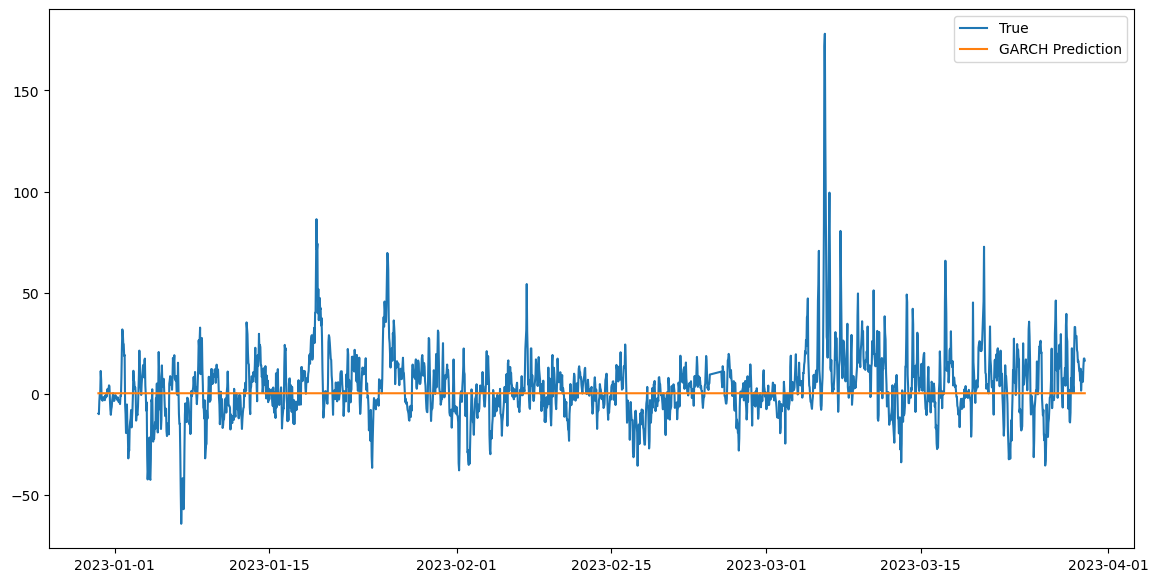

In [8]:
#!pip install arch
from arch import arch_model

# GARCH
garch_model = arch_model(y_train, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

# Prédictions GARCH
garch_pred = garch_result.forecast(horizon=len(y_test)).mean.values[-1, :]

# Visualisation
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, garch_pred, label='GARCH Prediction')
plt.legend()
plt.show()


In [9]:
# Calcul des erreurs
garch_rmse = mean_squared_error(y_test, garch_pred, squared=False)
garch_mape = mean_absolute_percentage_error(y_test, garch_pred)

print(f'GARCH RMSE: {garch_rmse}, MAPE: {garch_mape} %')



GARCH RMSE: 16.90549252068348, MAPE: 2.6842804856686824 %


C:\Users\thinkpad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 1/50
133/133 [==============================] - 17s 47ms/step - loss: 0.0203 - val_loss: 4.0161e-05
Epoch 2/50
133/133 [==============================] - 3s 23ms/step - loss: 2.8068e-04 - val_loss: 3.9863e-05
Epoch 3/50
133/133 [==============================] - 4s 28ms/step - loss: 2.8289e-04 - val_loss: 4.4182e-05
Epoch 4/50
133/133 [==============================] - 4s 31ms/step - loss: 2.8206e-04 - val_loss: 4.5584e-05
Epoch 5/50
133/133 [==============================] - 3s 25ms/step - loss: 2.8458e-04 - val_loss: 3.9806e-05
Epoch 6/50
133/133 [==============================] - 3s 25ms/step - loss: 2.8467e-04 - val_loss: 4.3633e-05
Epoch 7/50
133/133 [==============================] - 3s 24ms/step - loss: 2.8352e-04 - val_loss: 3.9779e-05
Epoch 8/50
133/133 [==============================] - 3s 25ms/step - loss: 2.8433e-04 - val_loss: 4.9179e-05
Epoch 9/50
133/133 [==============================] - 4s 30ms/step - loss: 2.8190e-04 - val_loss: 3.9698e-05
Epoch 10/50
133/133 [=

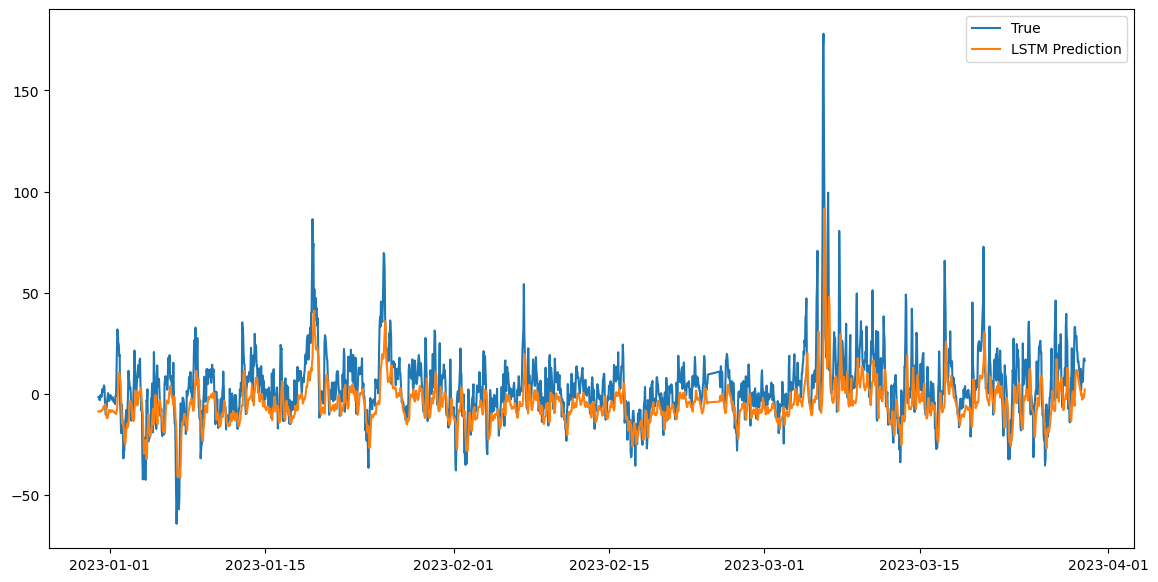

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Mise à l'échelle des données
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
scaled_test = scaler.transform(y_test.values.reshape(-1, 1))

# Préparation des données pour LSTM
def create_dataset(X, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step - 1):
        Xs.append(X[i:(i + time_step), 0])
        ys.append(X[i + time_step, 0])
    return np.array(Xs), np.array(ys)

time_step = 10
X_train, y_train_lstm = create_dataset(scaled_train, time_step)
X_test, y_test_lstm = create_dataset(scaled_test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Modèle LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
history = lstm_model.fit(X_train, y_train_lstm, validation_data=(X_test, y_test_lstm), epochs=50, batch_size=64, verbose=1)

# Prédictions LSTM
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

# Visualisation
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[time_step+1:], y_test[time_step+1:], label='True')
plt.plot(y_test.index[time_step+1:], lstm_pred, label='LSTM Prediction')
plt.legend()
plt.show()


In [11]:
# Calcul des erreurs
lstm_rmse = mean_squared_error(y_test[time_step+1:], lstm_pred, squared=False)
lstm_mape = mean_absolute_percentage_error(y_test[time_step+1:], lstm_pred)

print(f'LSTM RMSE: {lstm_rmse}, MAPE: {lstm_mape}')

LSTM RMSE: 15.221230787096232, MAPE: 69.92959074837081


C:\Users\thinkpad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


23:40:29 - cmdstanpy - INFO - Chain [1] start processing
23:40:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\thinkpad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Prophet RMSE: 16.818930156614243
Prophet MAPE: 12.650342010566643


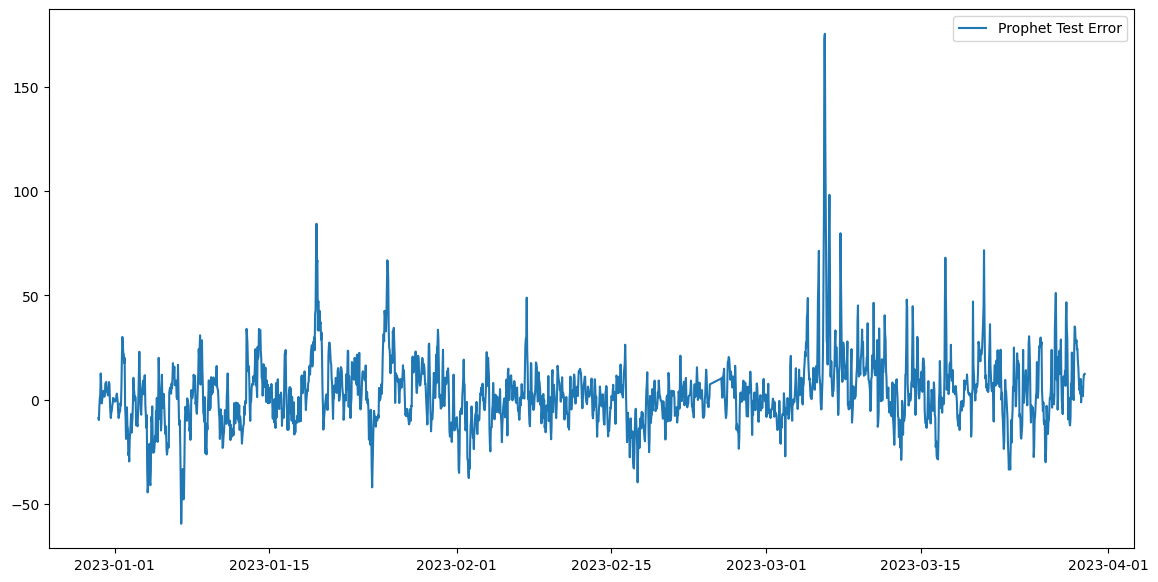

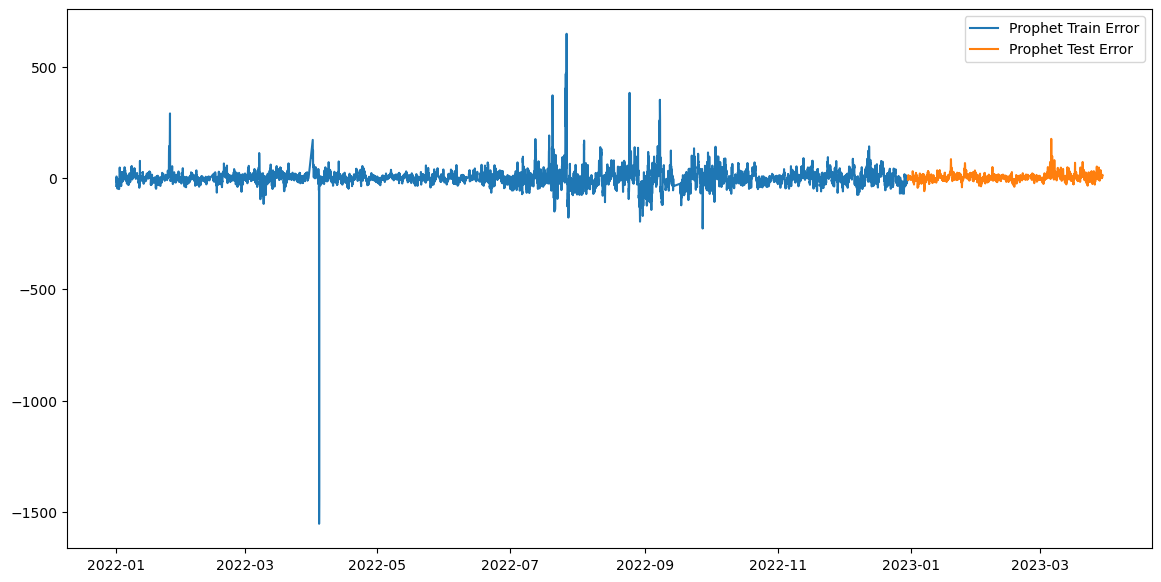

In [63]:
from prophet import Prophet
# Préparation des données pour Prophet
prophet_df = df[['spot_id_delta']].reset_index()
prophet_df.columns = ['ds', 'y']

# Séparation en train et test
prophet_train = prophet_df.iloc[:train_size]
prophet_test = prophet_df.iloc[train_size:]

# Modèle Prophet
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Prédictions Prophet
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='H')
forecast = prophet_model.predict(future)

# Calcul des erreurs
prophet_rmse = mean_squared_error(prophet_test['y'], forecast['yhat'].iloc[-len(prophet_test):], squared=False)
#prophet_mae = mean_absolute_error(prophet_test['y'], forecast['yhat'].iloc[-len(prophet_test):])
prophet_mape = mean_absolute_percentage_error(prophet_test['y'], forecast['yhat'].iloc[-len(prophet_test):])

print(f'Prophet RMSE: {prophet_rmse}')
#print(f'Prophet MAE: {prophet_mae}')
print(f'Prophet MAPE: {prophet_mape}')

# Visualisation des erreurs
plt.figure(figsize=(14, 7))
plt.plot(prophet_test['ds'], prophet_test['y'] - forecast['yhat'].iloc[-len(prophet_test):], label='Prophet Test Error')
plt.legend()
plt.show()

# Affichage des courbes d'entraînement et de test
prophet_train_error = prophet_train['y'] - forecast['yhat'][:len(prophet_train)]
prophet_test_error = prophet_test['y'] - forecast['yhat'][len(prophet_train):]

plt.figure(figsize=(14, 7))
plt.plot(prophet_train['ds'], prophet_train_error, label='Prophet Train Error')
plt.plot(prophet_test['ds'], prophet_test_error, label='Prophet Test Error')
plt.legend()
plt.show()

In [13]:
def predict_and_save_results(validation_data, lstm_model, scaler, output_file='predictions.csv'):
    # Mise à l'échelle des données de validation
    scaled_validation = scaler.transform(validation_data.values.reshape(-1, 1))
    
    # Préparation des données pour LSTM
    X_val, y_val = create_dataset(scaled_validation, time_step)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    
    # Prédictions LSTM
    lstm_pred = lstm_model.predict(X_val)
    lstm_pred = scaler.inverse_transform(lstm_pred)
    
    # Création du DataFrame pour les prédictions
    df_pred = pd.DataFrame({
        'DELIVERY_START': validation_data.index[time_step+1:],
        'spot_id_delta': lstm_pred.flatten()
    })
    
    # Sauvegarde des prédictions dans un fichier CSV
    df_pred.to_csv(output_file, index=False)
    
    print(f"Les prédictions ont été sauvegardées dans '{output_file}'.")

In [14]:
dataset_path = "https://raw.githubusercontent.com/robertmessan/ChallengeElmy/main/X_test_GgyECq8.csv"  # Remplacer par le chemin de votre fichier CSV

data = pd.read_csv(dataset_path)# Votre jeu de données de validation au format pandas.Series
data['DELIVERY_START']=data['DELIVERY_START'].apply(convertir_timestamp)


In [15]:
data.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2023-04-01 22:00:00,45814.0,3386.0,10902.0,36705.0,6359.0,0.0,56.764535,0.0,NaN
1,2023-04-01 23:00:00,44084.0,3386.0,10902.0,36705.0,6469.0,0.0,54.262133,0.0,NaN
2,2023-04-02 00:00:00,43281.0,3386.0,10902.0,36705.0,6511.0,0.0,78.105928,0.0,NaN
3,2023-04-02 01:00:00,40825.0,3386.0,10902.0,36705.0,6628.0,0.0,78.187557,0.0,NaN
4,2023-04-02 02:00:00,39181.0,3386.0,10902.0,36705.0,6700.0,0.0,96.765484,0.0,NaN


In [16]:
data.tail()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
4937,2023-10-24 17:00:00,49686.0,2226.0,11749.0,42980.0,4901.0,0.0,247.887323,0.0,125.67
4938,2023-10-24 18:00:00,53397.0,2226.0,11749.0,42980.0,5584.0,0.0,343.192642,0.0,139.58
4939,2023-10-24 19:00:00,50586.0,2226.0,11749.0,42980.0,6306.0,0.0,471.875973,0.0,147.93
4940,2023-10-24 20:00:00,46777.0,2226.0,11749.0,42980.0,6959.0,0.0,595.528100,0.0,122.20
4941,2023-10-24 21:00:00,46380.0,2226.0,11749.0,42980.0,7444.0,0.0,675.624809,0.0,105.12


Epoch 1/40
133/133 [==============================] - 10s 37ms/step - loss: 0.0188 - val_loss: 4.1919e-05
Epoch 2/40
133/133 [==============================] - 3s 20ms/step - loss: 2.8841e-04 - val_loss: 4.6055e-05
Epoch 3/40
133/133 [==============================] - 2s 17ms/step - loss: 2.9257e-04 - val_loss: 4.1304e-05
Epoch 4/40
133/133 [==============================] - 2s 18ms/step - loss: 2.8969e-04 - val_loss: 5.6441e-05
Epoch 5/40
133/133 [==============================] - 2s 18ms/step - loss: 2.8869e-04 - val_loss: 1.0352e-04
Epoch 6/40
133/133 [==============================] - 3s 20ms/step - loss: 2.9201e-04 - val_loss: 4.1189e-05
Epoch 7/40
133/133 [==============================] - 3s 20ms/step - loss: 2.9238e-04 - val_loss: 5.5922e-05
Epoch 8/40
133/133 [==============================] - 3s 19ms/step - loss: 2.9334e-04 - val_loss: 4.7593e-05
Epoch 9/40
133/133 [==============================] - 3s 19ms/step - loss: 2.9295e-04 - val_loss: 8.4724e-05
Epoch 10/40
133/133 [=

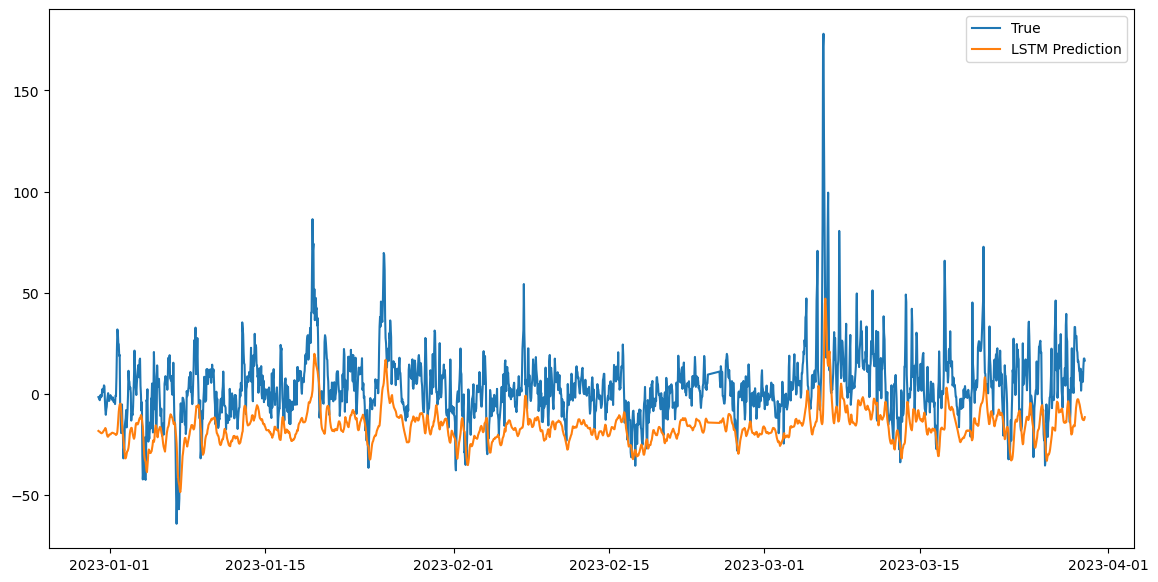

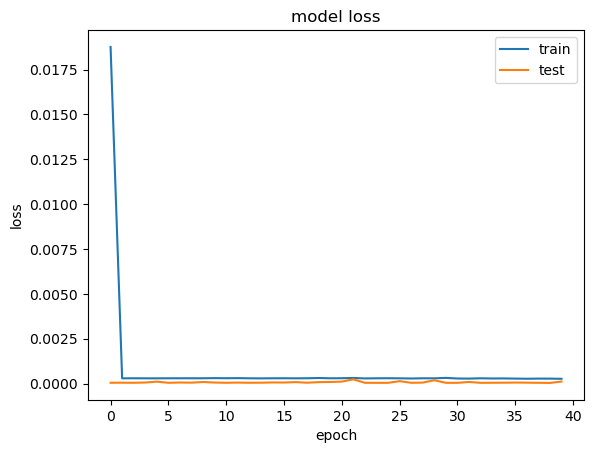

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Mise à l'échelle des données
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
scaled_test = scaler.transform(y_test.values.reshape(-1, 1))

# Préparation des données pour LSTM
def create_dataset(X, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step - 1):
        Xs.append(X[i:(i + time_step), 0])
        ys.append(X[i + time_step, 0])
    return np.array(Xs), np.array(ys)

time_step = 10
X_train, y_train_lstm = create_dataset(scaled_train, time_step)
X_test, y_test_lstm = create_dataset(scaled_test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Modèle LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
history = lstm_model.fit(X_train, y_train_lstm, validation_data=(X_test, y_test_lstm), epochs=40, batch_size=64, verbose=1)

# Prédictions LSTM
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

# Visualisation
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[time_step+1:], y_test[time_step+1:], label='True')
plt.plot(y_test.index[time_step+1:], lstm_pred, label='LSTM Prediction')
plt.legend()
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

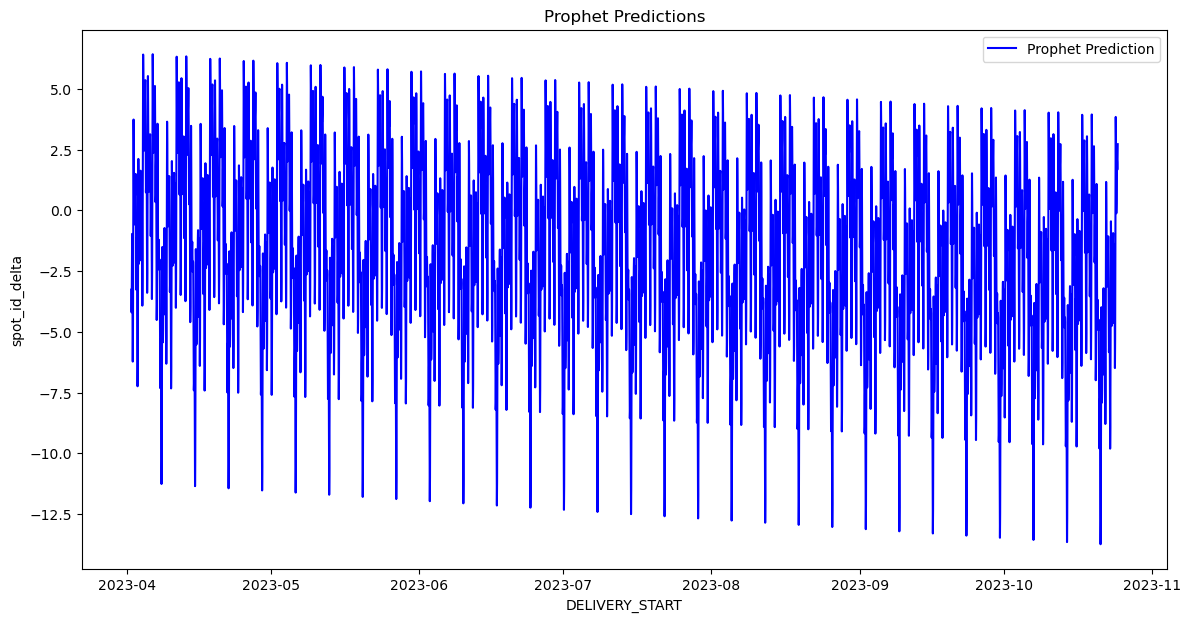

In [81]:
new_data = data
#new_data = new_data.set_index('DELIVERY_START')

# Déterminer la date minimale dans 'DELIVERY_START'
min_delivery_start = new_data['DELIVERY_START'].min()


# Prévisions futures à partir de la date minimale
future = pd.DataFrame({'ds': pd.date_range(start=min_delivery_start, periods=len(new_data), freq='H')})
forecast = prophet_model.predict(future)
# Renommer les colonnes dans les résultats
results = forecast[['ds', 'yhat']]
results.columns = ['DELIVERY_START', 'spot_id_delta']
results=results[['DELIVERY_START', 'spot_id_delta']]

# Sauvegarder les résultats dans un fichier CSV
results.to_csv('prophet_predictions.csv', index=False)

# Visualisation des prédictions
plt.figure(figsize=(14, 7))
plt.plot(results['DELIVERY_START'], results['spot_id_delta'], label='Prophet Prediction', color='b')
plt.legend()
plt.xlabel('DELIVERY_START')
plt.ylabel('spot_id_delta')
plt.title('Prophet Predictions')
plt.show()

In [85]:
results.to_csv("C:/Users/thinkpad/Downloads/Y_test.csv", index=False)

In [86]:
results

,DELIVERY_START,spot_id_delta
0,2023-04-01 22:00:00,-3.260102
1,2023-04-01 23:00:00,-4.196460
2,2023-04-02 00:00:00,-3.474443
3,2023-04-02 01:00:00,-1.797182
4,2023-04-02 02:00:00,-0.967379
...,...,...
4937,2023-10-24 15:00:00,2.113212
4938,2023-10-24 16:00:00,1.958579
4939,2023-10-24 17:00:00,1.672256
4940,2023-10-24 18:00:00,2.001835


In [68]:
data

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2023-04-01 22:00:00,45814.0,3386.0,10902.0,36705.0,6359.0,0.0,56.764535,0.0,NaN
1,2023-04-01 23:00:00,44084.0,3386.0,10902.0,36705.0,6469.0,0.0,54.262133,0.0,NaN
2,2023-04-02 00:00:00,43281.0,3386.0,10902.0,36705.0,6511.0,0.0,78.105928,0.0,NaN
3,2023-04-02 01:00:00,40825.0,3386.0,10902.0,36705.0,6628.0,0.0,78.187557,0.0,NaN
4,2023-04-02 02:00:00,39181.0,3386.0,10902.0,36705.0,6700.0,0.0,96.765484,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
4937,2023-10-24 17:00:00,49686.0,2226.0,11749.0,42980.0,4901.0,0.0,247.887323,0.0,125.67
4938,2023-10-24 18:00:00,53397.0,2226.0,11749.0,42980.0,5584.0,0.0,343.192642,0.0,139.58
4939,2023-10-24 19:00:00,50586.0,2226.0,11749.0,42980.0,6306.0,0.0,471.875973,0.0,147.93
4940,2023-10-24 20:00:00,46777.0,2226.0,11749.0,42980.0,6959.0,0.0,595.528100,0.0,122.20


In [69]:
new_data

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2023-04-01 22:00:00,45814.0,3386.0,10902.0,36705.0,6359.0,0.0,56.764535,0.0,NaN
1,2023-04-01 23:00:00,44084.0,3386.0,10902.0,36705.0,6469.0,0.0,54.262133,0.0,NaN
2,2023-04-02 00:00:00,43281.0,3386.0,10902.0,36705.0,6511.0,0.0,78.105928,0.0,NaN
3,2023-04-02 01:00:00,40825.0,3386.0,10902.0,36705.0,6628.0,0.0,78.187557,0.0,NaN
4,2023-04-02 02:00:00,39181.0,3386.0,10902.0,36705.0,6700.0,0.0,96.765484,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
4937,2023-10-24 17:00:00,49686.0,2226.0,11749.0,42980.0,4901.0,0.0,247.887323,0.0,125.67
4938,2023-10-24 18:00:00,53397.0,2226.0,11749.0,42980.0,5584.0,0.0,343.192642,0.0,139.58
4939,2023-10-24 19:00:00,50586.0,2226.0,11749.0,42980.0,6306.0,0.0,471.875973,0.0,147.93
4940,2023-10-24 20:00:00,46777.0,2226.0,11749.0,42980.0,6959.0,0.0,595.528100,0.0,122.20


In [76]:
train_data.columns

Index(['DELIVERY_START', 'load_forecast', 'coal_power_available',
       'gas_power_available', 'nucelear_power_available',
       'wind_power_forecasts_average', 'solar_power_forecasts_average',
       'wind_power_forecasts_std', 'solar_power_forecasts_std',
       'predicted_spot_price', 'spot_id_delta'],
      dtype='object')